# Nice to Meat You : An Analysis on Meat Consumption

## Introduction

Meat consumption is a highly controversial topic in nowadays society in terms of [environment](https://www.theguardian.com/environment/2018/oct/10/huge-reduction-in-meat-eating-essential-to-avoid-climate-breakdown), [health](https://gamechangersmovie.com/), and [ethical](http://traslosmuros.com/en/slaughterhouse-documentary/) reasons. This situation introduces different ways of consuming meat and divides people according to their behaviors such as vegan, vegetarian, occasional meat consumer, and people consuming large amounts of meats.

In this project, we are particularly interested in the factors related to consuming meat and how the behavior of households varies according to their meat consumption. We are going to focus on demographic information such as economic status, family composition, age, and their relation with consuming meat. Moreover, we are going to study external effects that are related to meat consumption such as seasonal changes, campaigns, and discounts. Finally, we are going to categorize households according to their meat consumption and perform a behavior analysis per category.

To do so, we are going to use the Dunnhumby dataset. This dataset contains shopping information collected over two years from a group of 2,500 households as well as their information for each household. Moreover, we are planning to expand our analysis with an additional dataset about nutritional information.


## Factors that influence meat consumption

### Loading the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

## Product Table

The first step is to select the meat products in the products dataset. The products are classified at three different categories levels. The broadest category is 'DEPARTMENT'.

In [2]:
products = pd.read_csv('dunnhumby/product.csv', sep = ',')
products['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [3]:
# Select the meat departments
meat_dept = ['MEAT-PCKGD','MEAT','MEAT-WHSE','PORK']
meat_products = products[products['DEPARTMENT'].isin(meat_dept)].copy()

The 'DELI' department also contains meat but not exclusively. It is therefore necessary to select the 'COMMODITY_DESC' amongst the 'DELI' department containing exclusively meat.

In [4]:
deli_products = products[products['DEPARTMENT'] == 'DELI']
deli_products['COMMODITY_DESC'].unique()

array(['SALADS/DIPS', 'SANDWICHES', 'DELI MEATS', 'CHEESES',
       'CHICKEN/POULTRY', 'SNACKS', 'PREPARED FOOD', 'COFFEE SHOP',
       'DELI SPECIALTIES (RETAIL PK)', 'PARTY TRAYS', 'SERVICE BEVERAGE',
       'SUSHI', 'DELI SUPPLIES'], dtype=object)

In [5]:
# Select the meat commodities amongst the 'DELI' department
meat_commodity = ['DELI MEATS','CHICKEN/POULTRY']
meat_products.append(products[products['COMMODITY_DESC'].isin(meat_commodity)])
meat_products['SUB_COMMODITY_DESC'].unique()

array(['FRESH', 'FRZN BREADED PREPARED CHICK', 'BREAST - BONELESS(IQF)',
       'BOLOGNA', 'LINKS - COOKED', 'LUNCH COMBO', 'BETTER FOR YOU',
       'LINKS - RAW', 'CORN DOGS', 'KOSHER/SPECIALTY', 'CHICKEN WINGS',
       'HAM', 'CHICKEN BREAST BONE IN', 'SELECT BEEF', 'LOAVE',
       'PEPPERONI/SALAMI', 'SAUERKRAUT', 'MISCELLANEOUS', 'ENTREES',
       'PRIMAL', 'POULTRY', 'SMOKED/COOKED',
       'SMOKED/COOKED - BETTER FOR YOU', 'PREMIUM - BEEF',
       'GROUND TURKEY', 'PICKLES', 'BREAST - BONE-IN (IQF)', 'PREMIUM',
       'STUFFED/MIXED BEEF', 'PATTIES - RAW', 'ROLLS - PORK',
       'VARIETY PACK', 'PREMIUM - MEAT', 'SALADS', 'CHICKEN-FULLY COOKED',
       'HAMS-DRY CURED/COUNTRY', 'FRZN BURGERS/BBQ/MEATBALL',
       'ROLLS - FLAVORED/OTHER', 'ECONOMY', 'PRE-COOKED',
       'PORK-FULLY COOKED', 'CHICKEN DRUMS', 'ECONOMY - MEAT',
       'CHOICE BEEF', 'EXTERNAL', 'DRY', 'BUTTS', 'NATURAL BEEF',
       'WHOLE HENS (UNDER 15LBS)', 'SOUP/STEW', 'LEAN', 'CUBED MEATS',
       'CHICKEN BREA

With these steps, we have selected all the products containing only meat. A second step allows to select all the products containing meat.

In [6]:
# products containing meat selected from their 'COMMODITY_DESC' and 'SUB_COMMODITY_DESC' sections
cont_meat_commodity = ['MEAT - SHELF STABLE','FROZEN CHICKEN','FRZN MEAT/MEAT DINNERS']
cont_meat_sub_commodity = ['DELI TRAY:MEAT AND CHEESE','MEAT ADDED']
cont_meat = products[products['COMMODITY_DESC'].isin(cont_meat_commodity)]
cont_meat.append(products[products['SUB_COMMODITY_DESC'].isin(cont_meat_sub_commodity)])
# remove vegetarian meat options 
cont_meat = cont_meat[cont_meat['SUB_COMMODITY_DESC'].isin(['FRZN MEAT ALTERNATIVES' ,'FROZEN MEAT (VEGETARIAN)']) == 0].copy()
cont_meat['SUB_COMMODITY_DESC'].unique()

array(['FRZN SS PREMIUM ENTREES/DNRS/T', 'FRZN MULTI SERVE ENTREES ALL',
       'MICROWAVABLE CUPS', 'CHILI: CANNED', 'BEEF STEW',
       'HOT DOG CHILI SAUCE', 'PASTA: CANNED',
       'FRZN BREADED PREPARED CHICK', 'FRZN SS PREMIUM ENTREES/DNRS/N',
       'SANDWICH SAUCE', 'VIENNA SAUSAGE',
       'SS ECONOMY ENTREES/DINNERS ALL', 'CHUNK MEATS - ALL',
       'LUNCHEON MEAT', 'FROZEN PASTA', 'CHICKEN-FULLY COOKED',
       'TAMALES (STOCKED N/CANNED MEAT', 'SNACKS/APPETIZERS', 'MICROWAVE',
       'HASH: CANNED', 'POULTRY - STEW W/DUMPLINGS/ A',
       'BEEF/PORK - DRIED SLICED W/GRA', 'POTTED MEATS AND SPREADS',
       'FROZEN ENTREES', 'CORN BEEF', 'MISC CND MEATS',
       'FRZN REGIONAL/OTHER', 'PIZZA/PREMIUM',
       'FRZN BURGERS/BBQ/MEATBALL', 'PORK-FULLY COOKED', 'KITES',
       'GRASS/SHRED'], dtype=object)

In [7]:
products.groupby('DEPARTMENT').count()['PRODUCT_ID'].sort_values(ascending = False)

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
POSTAL CENTER          3
DAIRY DELI             3
TOYS                   3
VIDEO RENTAL           3
GM MERCH EXP           3
PHOTO                  2
DELI/SNACK BAR         2
PROD-WHS SALES         2
GRO BAKERY             2
CHARITABLE CONT        2
AUTOMOTIVE             2
VIDEO                  2
PORK                   1
ELECT &PLUMBIN

In [8]:
# meat_products.to_csv('data/meat_products.csv')
# cont_meat.to_csv('data/cont_meat.csv')

## Transactions Table

### First look at the table

In [15]:
transactions = pd.read_csv('dunnhumby/transaction_data.csv', sep = ',')

In [16]:
transactions.head(10)

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   
5           2375  26984851516    1      826249         2         1.98   
6           2375  26984851516    1     1043142         1         1.57   
7           2375  26984851516    1     1085983         1         2.99   
8           2375  26984851516    1     1102651         1         1.89   
9           2375  26984851516    1     6423775         1         2.00   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0  
5       364        -0.60        1642        1          0.0                0.0  
6       364        -0.68        1642        1          0.0                0.0  
7       364        -0.40        1642        1          0.0                0.0  
8       364         0.00        1642        1          0.0                0.0  
9       364        -0.79        1642        1          0.0                0.0

### Create the PAID PRICE column

In [17]:
transactions["PAID_PRICE"] = (transactions.SALES_VALUE - (transactions.RETAIL_DISC.abs() + transactions.COUPON_MATCH_DISC.abs())) / transactions.QUANTITY
transactions["PAID_PRICE"] = transactions["PAID_PRICE"].clip(lower=0)

In [18]:
transactions.head(5)

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  \
0       364        -0.60        1631        1          0.0                0.0   
1       364         0.00        1631        1          0.0                0.0   
2       364        -0.30        1631        1          0.0                0.0   
3       364         0.00        1631        1          0.0                0.0   
4       364        -0.39        1631        1          0.0                0.0   

   PAID_PRICE  
0        0.79  
1        0.82  
2        0.69  
3        1.21  
4        1.11

### What is the most exapansive transaction ?

In [19]:
transactions[transactions.PAID_PRICE == transactions.PAID_PRICE.max()]

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY   SALES_VALUE  \
6032              2263  27130336063   13      986912         0  7.000000e-02   
136410             435  28085360560   91     2614183         0  4.000000e-02   
211149             454  28344946496  114      914513         0  5.551115e-17   
211156             454  28344946496  114      973673         0  5.551115e-17   
304499             932  28757625745  138      858732         0  6.661338e-16   
418897             164  29221697692  168      953476         0  2.220446e-16   
479956            1397  29484505655  184      981760         0  4.440892e-16   
481329             156  29484720645  185      839147         0  1.000000e-02   
542027             683  29847806846  203       57059         0  1.000000e-02   
637766            2035  30217406304  226      866871         0  5.820000e+00   
802997            2345  30995812608  268      873026         0  1.000000e-02   
845578             830  31134745920  279      956995         0  1.000000e-02   
946650            1907  31502778568  304      866858         0  5.000000e-01   
965012             143  31553913307  309     5995423         0  1.000000e-02   
1038363             57  31833823621  326     8290932         0  1.776357e-15   
1119126           2066  32091052122  347     1102453         0  1.000000e-02   
1148487           1306  32186616885  354      979707         0  1.000000e-02   
1166021            989  32231877896  358     5569135         0  1.776357e-15   
1216489           2491  32478901200  370    13945244         0  4.440892e-16   
1275773            476  32715971394  385      947658         0  4.440892e-16   
1303000            768  32811720098  392      878234         0  1.000000e-02   
1323967            805  32872680708  397      965821         0  4.440892e-16   
1353959           1078  32990011524  405      983918         0  1.000000e-02   
1375518            369  33041701180  410      942088         0  1.000000e-02   
1378202           2360  33065462454  412     1093910         0  8.881784e-16   
1387829            955  33094796501  413      824555         0  5.551115e-17   
1388007            588  33094808535  413    12577242         0  2.220446e-16   
1406151            544  33155296085  418      908273         0  2.220446e-16   
1412000            534  33167922336  419     1032396         0  4.440892e-16   
1451853            256  33316338041  429     1137688         0  6.000000e-01   
1501400           1962  33472677073  440      972143         0  3.200000e-01   
1519567           1177  33655010327  446     1043260         0  1.000000e-02   
1546063            366  33658927628  452     1081177         0  1.090000e+00   
1548521           2407  33659282828  453      848355         0  2.220446e-16   
1609441           1798  33957321154  468      993639         0  4.900000e-01   
1640792            830  34045418146  475     9837842         0  1.000000e-02   
1692181           1916  34258602842  489      978265         0  2.610000e+00   
1713281            325  34573678291  495      957422         0  8.900000e-01   
1760927            676  34837161951  506     9834988         0  4.440892e-16   
1822395           1795  35463825026  522     1082185         0  5.700000e-01   
1873236           1506  35730355266  534     1044676         0  2.000000e-02   
1877009            367  35840831094  535     9879410         0  2.220446e-16   
1882001           1664  35841625986  536      859426         0  8.881784e-16   
1913203           1419  40013987538  544      987480         0  1.000000e-02   
1949534            878  40127351835  554     1128665         0  1.000000e-02   
1976697           1279  40222916853  561      854852         0  8.000000e-02   
2054524           1529  40460670731  580     1076056         0  1.000000e-01   
2071065           1506  40510440945  584      989824         0  1.450000e+00   
2090965            127  40577625488  590      836043         0  8.881784e-16   
2149005  

In [20]:
products[products.PRODUCT_ID == 1089093]

PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND  \
36327     1089093             2  MISC. TRANS.  National   

                 COMMODITY_DESC           SUB_COMMODITY_DESC  \
36327  NO COMMODITY DESCRIPTION  NO SUBCOMMODITY DESCRIPTION   

      CURR_SIZE_OF_PRODUCT  
36327

### When do people do their groceries ?

0    1744
dtype: int64

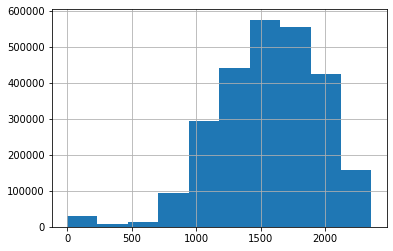

In [21]:
transactions.TRANS_TIME.hist()
transactions.TRANS_TIME.mode()

### How many unique stores ?

In [22]:
len(transactions.STORE_ID.unique())

582

### How many transactions?

In [23]:
print("Number of transactions: ")
len(transactions)

Number of transactions: 


2595732

### How many baskets ?

In [24]:
print("Number of baskets: ")
len(transactions.BASKET_ID.unique())

Number of baskets: 


276484

### How many products ?

In [25]:
print("Number of products: ")
len(transactions.PRODUCT_ID.unique())

Number of products: 


92339

### Are there an NAN values ?

In [26]:
transactions.isna().any()

household_key        False
BASKET_ID            False
DAY                  False
PRODUCT_ID           False
QUANTITY             False
SALES_VALUE          False
STORE_ID             False
RETAIL_DISC          False
TRANS_TIME           False
WEEK_NO              False
COUPON_DISC          False
COUPON_MATCH_DISC    False
PAID_PRICE            True
dtype: bool

In [27]:
transactions = transactions[transactions.QUANTITY > 0]

In [28]:
transactions.isna().any()

household_key        False
BASKET_ID            False
DAY                  False
PRODUCT_ID           False
QUANTITY             False
SALES_VALUE          False
STORE_ID             False
RETAIL_DISC          False
TRANS_TIME           False
WEEK_NO              False
COUPON_DISC          False
COUPON_MATCH_DISC    False
PAID_PRICE           False
dtype: bool

### What is the distribution of the basket price ?

Mean basket price: 19.13
Median basket price: 9.82


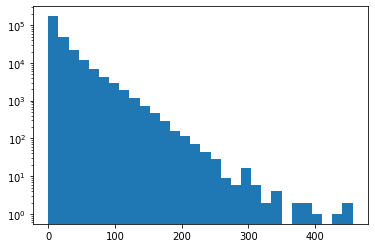

In [29]:
basket_prices = transactions.groupby("BASKET_ID").PAID_PRICE.sum()

print("Mean basket price: %.2f" % basket_prices.mean())
print("Median basket price: %.2f" % basket_prices.median())
plt.hist(basket_prices, bins=30)
plt.yscale("log")

In [30]:
basket_prices.sort_values(ascending=True)

BASKET_ID
31097462932      0.000000
27889003265      0.000000
28141111258      0.000000
29170533146      0.000000
40911601699      0.000000
                  ...    
33347880492    390.803333
27093315740    400.790000
29712930072    437.580000
32187143334    449.990000
30031850855    456.500000
Name: PAID_PRICE, Length: 275889, dtype: float64

We see that there are some baskets that cost 0 dollars. Let's have a look at one of these baskets :

In [31]:
transactions[transactions.BASKET_ID == 29170533146]

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
403689            618  29170533146  165     1053460         1          0.0   

        STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
403689       316          0.0        1834       24          0.0   

        COUPON_MATCH_DISC  PAID_PRICE  
403689                0.0         0.0

In [32]:
products[products.PRODUCT_ID == 1053460]

PRODUCT_ID  MANUFACTURER      DEPARTMENT     BRAND  \
32332     1053460          2745  COUP/STR & MFG  National   

            COMMODITY_DESC   SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
32332  COUPONS/STORE & MFG  COUPONS/STORE & MFG

### In Which department are there the most retail discounts ?

In [33]:
transactions_with_discount = transactions[transactions.RETAIL_DISC < 0.0]
transac_prod_with_disc = pd.merge(transactions_with_discount, products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "RETAIL_DISC", "DEPARTMENT"]]

In [34]:
prodcts_by_dep = products.groupby("DEPARTMENT").count()["PRODUCT_ID"]
transac_by_dep = transac_prod_with_disc.groupby("DEPARTMENT").count()["RETAIL_DISC"]
normalized_discount_by_dep = transac_by_dep / prodcts_by_dep
normalized_discount_by_dep.sort_values(ascending=False)

DEPARTMENT
KIOSK-GAS          1266.625000
MISC SALES TRAN      32.704545
MEAT-PCKGD           28.993407
GROCERY              24.326952
SALAD BAR            22.958333
PRODUCE              19.802117
MEAT                 18.695755
SEAFOOD-PCKGD        12.925400
DELI                 11.215378
TRAVEL & LEISUR       9.071429
PASTRY                6.019544
CHEF SHOPPE           5.714286
DAIRY DELI            5.666667
PHARMACY SUPPLY       5.000000
COUP/STR & MFG        5.000000
NUTRITION             4.927591
SEAFOOD               4.604336
PHOTO                 3.000000
DRUG GM               2.634749
HBC                   2.000000
FROZEN GROCERY        1.521739
VIDEO RENTAL          1.333333
COSMETICS             0.990037
GARDEN CENTER         0.546875
CHARITABLE CONT       0.500000
GM MERCH EXP          0.333333
POSTAL CENTER         0.333333
TOYS                  0.333333
FLORAL                0.303838
MISC. TRANS.          0.289796
RESTAURANT            0.137255
                           N

### What is the average paid price by Department ?

In [35]:
transac_prod = pd.merge(transactions, products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "PAID_PRICE", "DEPARTMENT"]]

In [36]:
average_price_by_dep = transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].mean().sort_values(ascending=False)
average_price_by_dep

DEPARTMENT
VIDEO              11.590000
RX                 11.040714
SPIRITS             9.513825
PORK                7.850000
FLORAL              7.682257
AUTOMOTIVE          6.515556
GARDEN CENTER       5.903099
SEAFOOD             5.221887
MISC SALES TRAN     4.404429
RESTAURANT          4.023587
MISC. TRANS.        3.675989
MEAT                3.590639
DELI                3.588190
COSMETICS           3.279909
SEAFOOD-PCKGD       3.235831
DELI/SNACK BAR      3.229091
DRUG GM             3.086602
HOUSEWARES          2.990000
SALAD BAR           2.879742
PASTRY              2.540724
CHEF SHOPPE         2.537343
TRAVEL & LEISUR     2.532891
CNTRL/STORE SUP     2.502778
FROZEN GROCERY      2.338138
MEAT-PCKGD          2.291395
NUTRITION           2.177085
HBC                 2.020000
PROD-WHS SALES      1.880000
PHOTO               1.821765
GM MERCH EXP        1.738587
PRODUCE             1.721675
GROCERY             1.692921
PHARMACY SUPPLY     1.656667
CHARITABLE CONT     1.625000
TOY

### What is the average size of a basket ?

In [37]:
transactions.groupby("BASKET_ID").count()["PRODUCT_ID"].mean()

9.356175853332319

### How does the basket price evolve over weeks ?

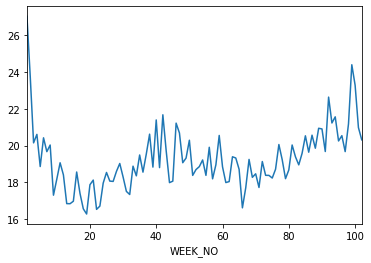

In [38]:
basket_values = transactions.groupby("BASKET_ID").agg({"PAID_PRICE": sum, "WEEK_NO": "first"}).reset_index()
avg_basket_value_per_week = basket_values.groupby("WEEK_NO")["PAID_PRICE"].mean()
avg_basket_value_per_week.plot()
# basket_value_per_week.sort_values(ascending=False)

In [67]:
meat_transactions = pd.merge(meat_products, transactions, on="PRODUCT_ID", how="inner")
cont_meat_transactions =pd.merge(cont_meat, transactions, on="PRODUCT_ID", how="inner")

meat_transactions = pd.concat([meat_transactions, cont_meat_transactions])


In [73]:
print(len(meat_transactions))

278590


In [68]:
total_spent_for_meat = meat_transactions.PAID_PRICE.sum()
total_spent = transactions.PAID_PRICE.sum()

print("Percentage of money spent for meat: %.2f percent" % ((total_spent_for_meat / total_spent) * 100) )

Percentage of money spent for meat: 13.05 percent


In [69]:
spent_for_meat_by_household = meat_transactions.groupby("household_key").PAID_PRICE.sum()
spent_by_household = transactions.groupby("household_key").PAID_PRICE.sum()

In [74]:
max(spent_for_meat_by_household)
spent_for_meat_by_household.mean()

279.25797675601495

In [83]:
transactions.groupby("PRODUCT_ID").PAID_PRICE.sum().sort_values(ascending=False)

PRODUCT_ID
1029743     33056.937667
6533765     28837.270000
1082185     26092.550611
1106523     22585.922000
844179      11119.716216
                ...     
9300540         0.000000
15797006        0.000000
1748345         0.000000
1746040         0.000000
2710420         0.000000
Name: PAID_PRICE, Length: 92015, dtype: float64

In [88]:
products[products.PRODUCT_ID == 844179]

PRODUCT_ID  MANUFACTURER DEPARTMENT     BRAND COMMODITY_DESC  \
8722      844179          2852       MEAT  National           BEEF   

     SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
8722             PRIMAL